<a href="https://colab.research.google.com/github/manu6521/Image_project/blob/main/Copy_of_image_captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import modules


In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,LSTM,Dense,Embedding,Dropout,add
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

In [2]:
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!mkdir -p /content/flickr_new


In [4]:
!unzip '/content/drive/MyDrive/flicker/Flickr8k_Dataset.zip' -d /content/flickr_new


Streaming output truncated to the last 5000 lines.
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._342872408_04a2832a1b.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429142249_d09a32e291.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429142249_d09a32e291.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429194423_98e911a101.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429194423_98e911a101.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429351222_17ae744daf.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429351222_17ae744daf.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429351964_531de1bf16.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429351964_531de1bf16.jpg  
  inflating: /content/flickr_new/Flicker8k_Dataset/3429391520_930b153f94.jpg  
  inflating: /content/flickr_new/__MACOSX/Flicker8k_Dataset/._3429391520_930b153f94.jpg  
  inflating: /c

In [5]:
dir_new = '/content/flickr_new/Flicker8k_Dataset/'
dir_cap = '/content/flickr_new/'

In [6]:
#printing number of images
df = os.listdir(dir_new)
print(len(df))

8091


In [7]:
#model
model = VGG16()
model = Model(inputs = model.inputs,outputs = model.layers[-2].output)
print(model.summary())


553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [8]:
#extract features from image
features = { }
'''for img_name in tqdm(os.listdir(dir_new)):
  # load image from file
  image_path = dir_new + '/' + img_name
  image = load_img(image_path, target_size=(224,224))
  # convert image pixels to numpy array
  image = img_to_array(image)
  #reshape data for model
  image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  #preprocess image for vgg16
  image = preprocess_input(image)
  #extract feature
  feature = model.predict(image,verbose=0)
  #get image id
  image_id = img_name.split('.')[0]
  #store features
  features[image_id] = feature   '''

"for img_name in tqdm(os.listdir(dir_new)):\n  # load image from file\n  image_path = dir_new + '/' + img_name\n  image = load_img(image_path, target_size=(224,224))\n  # convert image pixels to numpy array\n  image = img_to_array(image)\n  #reshape data for model\n  image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))\n  #preprocess image for vgg16\n  image = preprocess_input(image)\n  #extract feature\n  feature = model.predict(image,verbose=0)\n  #get image id\n  image_id = img_name.split('.')[0]\n  #store features\n  features[image_id] = feature   "

In [9]:

#store features in pickle
pickle.dump(features, open(os.path.join(dir_new, 'ex_features.pkl'), 'wb'))

In [10]:
# load feature from pickle
with open(os.path.join(dir_new, 'ex_features.pkl'), 'rb') as f:
  ex_features = pickle.load(f)


In [11]:
!unzip '/content/drive/MyDrive/captions.txt.zip' -d /content/flickr_new

Archive:  /content/drive/MyDrive/captions.txt.zip
  inflating: /content/flickr_new/captions.txt  


In [12]:
with open(os.path.join(dir_cap, 'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()




In [13]:
#create mapping of images to captions
mapping = { }
# process line
for line in tqdm(captions_doc.split('\n')):
#split line by comma
  tokens = line.split(',')
  if len(line)<2:
    continue
  image_id, caption = tokens[0], tokens[1:]
  #remove extension from image id
  image_id = image_id.split('.')[0]
  # convert caption list to a string
  caption = " ".join(caption)
  # create list if needed
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)

print(mapping[image_id])

  0%|          | 0/40456 [00:00<?, ?it/s]

['A man in a pink shirt climbs a rock face', 'A man is rock climbing high in the air .', 'A person in a red shirt climbing up a rock face covered in assist handles .', 'A rock climber in a red shirt .', 'A rock climber practices on a rock climbing wall .']


In [14]:
# preprocess caption
def clean_cap(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      caption = captions[i]
      # convert to lowercase
      caption = caption.lower()
      # deleting special chars, digits
      caption = caption.replace('[^A-Za-z]','')
      # removing additional spaces
      caption = caption.replace('\s+',' ')
      # add <start> and <end> tag
      caption = " ".join([word for word in caption.split() if len(word)>1])
      caption = '<start> ' + caption + ' <end>'
      captions[i] = caption




In [15]:
# before preprocess
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [16]:
# calling cleaning function
clean_cap(mapping)

In [17]:
# after preprocessing
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [18]:
# saving all the caption in single list
final_captions = []
for key in mapping:
  for caption in mapping[key]:
    final_captions.append(caption)

In [19]:
len(final_captions)

40455

In [20]:
# text tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(final_captions)
vocab_size = len(tokenizer.word_index) + 1

In [21]:
#findimg maximum length of caption
length_max = max(len(caption.split()) for caption in final_captions)
length_max

35

## Train_test_split

In [22]:
# taking image ids
image_ids = list(mapping.keys())
split = int(len(image_ids) *0.90)
train = image_ids[:split]
test  = image_ids[split:]

In [34]:
# length of dataset
print('Length of training data:' + str(len(train)))
print('Length of test data:' + str(len(test)))


Length of training data:7281
Length of test data:810


In [42]:
## Create generator to get data in batch

def Data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
  # looping through images
  X1, X2, y = list(), list(), list()
  n = 0
  while 1:
    for key in data_keys:
      n += 1
      captions = mapping[key]
      # taking each captions
      for caption in captions:
        seq = tokenizer.texts_to_sequences([captions])[0]
        # split to X,y pairs
        for i in range(1, len(seq)):
          input_seq, output_seq = seq[:i], seq[i]
          #padding
          input_seq = pad_sequences([input_seq], maxlen = max_length)[0]
          output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
          # storing sequences
          X1.append(features[key][0])
          X2.append(input_seq)
          y.append(output_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield [X1, X2], y
        X1, X2, y = list(), list(), list()
        n = 0



## CREATING MODEL

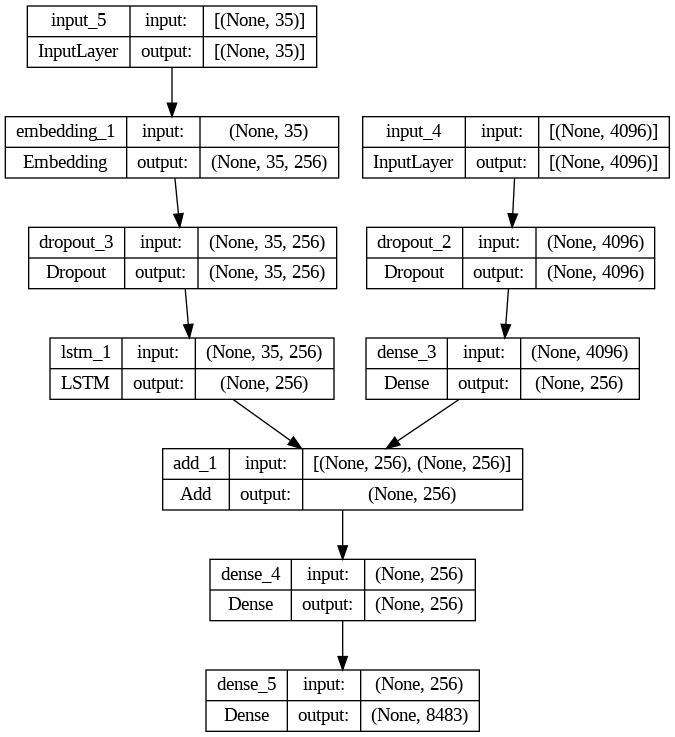

In [49]:
# IMAGE LAYERS
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation = 'relu')(fe1)
# sequence layers
inputs2 = Input(shape=(length_max,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder_model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs = [inputs1, inputs2], outputs = outputs)
model.compile(loss ='categorical_crossentropy',optimizer = 'adam')

#Model_plotting
plot_model(model, show_shapes=True)


In [ ]:
########